##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Post-training dynamic range quantization

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/performance/post_training_quant"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_quant.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_quant.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/lite/g3doc/performance/post_training_quant.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

[TensorFlow Lite](https://www.tensorflow.org/lite/) now supports
converting weights to 8 bit precision as part of model conversion from
tensorflow graphdefs to TensorFlow Lite's flat buffer format. Dynamic range quantization achieves a 4x reduction in the model size. In addition, TFLite supports on the fly quantization and dequantization of activations to allow for:

1.  Using quantized kernels for faster implementation when available.
2.  Mixing of floating-point kernels with quantized kernels for different parts
    of the graph.

The activations are always stored in floating point. For ops that
support quantized kernels, the activations are quantized to 8 bits of precision
dynamically prior to processing and are de-quantized to float precision after
processing. Depending on the model being converted, this can give a speedup over
pure floating point computation.

In contrast to
[quantization aware training](https://github.com/tensorflow/tensorflow/tree/r1.14/tensorflow/contrib/quantize)
, the weights are quantized post training and the activations are quantized dynamically 
at inference in this method.
Therefore, the model weights are not retrained to compensate for quantization
induced errors. It is important to check the accuracy of the quantized model to
ensure that the degradation is acceptable.

This tutorial trains an MNIST model from scratch, checks its accuracy in
TensorFlow, and then converts the model into a Tensorflow Lite flatbuffer
with dynamic range quantization. Finally, it checks the
accuracy of the converted model and compare it to the original float model.

## Build an MNIST model

### Setup

In [1]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib

### Train a TensorFlow model

In [2]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=1,
  validation_data=(test_images, test_labels)
)

1875/1875 [==============================] - 20s 10ms/step - loss: 0.2760 - accuracy: 0.9220 - val_loss: 0.1434 - val_accuracy: 0.9573


For the example, since you trained the model for just a single epoch, so it only trains to ~96% accuracy.


### Convert to a TensorFlow Lite model

Using the Python [TFLiteConverter](https://www.tensorflow.org/lite/convert/python_api), you can now convert the trained model into a TensorFlow Lite model.

Now load the model using the `TFLiteConverter`:

In [3]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp2tbl2bfw/assets


Write it out to a tflite file:

In [4]:
tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [5]:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

84552

To quantize the model on export, set the `optimizations` flag to optimize for size:

In [6]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpulkq8slc/assets


INFO:tensorflow:Assets written to: /tmp/tmpulkq8slc/assets


23952

Note how the resulting file, is approximately `1/4` the size.

In [7]:
!ls -lh {tflite_models_dir}

total 108K
-rw-r--r-- 1 root root 24K Jun 12 07:11 mnist_model_quant.tflite
-rw-r--r-- 1 root root 83K Jun 12 07:11 mnist_model.tflite


## Run the TFLite models

Run the TensorFlow Lite model using the Python TensorFlow Lite
Interpreter.


### Load the model into an interpreter

In [8]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [9]:
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

### Test the model on one image

In [11]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

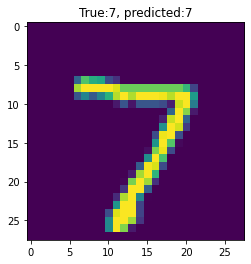

In [12]:
import matplotlib.pylab as plt

plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

### Evaluate the models

In [13]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [14]:
print(evaluate_model(interpreter))

0.9573


Repeat the evaluation on the dynamic range quantized model to obtain:


In [15]:
print(evaluate_model(interpreter_quant))

0.957


In this example, the compressed model has no difference in the accuracy.

## Optimizing an existing model

Resnets with pre-activation layers (Resnet-v2) are widely used for vision applications.
  Pre-trained frozen graph for resnet-v2-101 is available on
  [Tensorflow Hub](https://tfhub.dev/google/imagenet/resnet_v2_101/classification/4).

You can convert the frozen graph to a TensorFLow Lite flatbuffer with quantization by:


In [16]:
import tensorflow_hub as hub

resnet_v2_101 = tf.keras.Sequential([
  keras.layers.InputLayer(input_shape=(224, 224, 3)),
  hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_101/classification/4")
])

converter = tf.lite.TFLiteConverter.from_keras_model(resnet_v2_101)

In [17]:
# Convert to TF Lite without quantization
resnet_tflite_file = tflite_models_dir/"resnet_v2_101.tflite"
resnet_tflite_file.write_bytes(converter.convert())

INFO:tensorflow:Assets written to: /tmp/tmp8ol3_169/assets


INFO:tensorflow:Assets written to: /tmp/tmp8ol3_169/assets


178538036

In [18]:
# Convert to TF Lite with quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
resnet_quantized_tflite_file = tflite_models_dir/"resnet_v2_101_quantized.tflite"
resnet_quantized_tflite_file.write_bytes(converter.convert())

INFO:tensorflow:Assets written to: /tmp/tmpdcvctwuz/assets


INFO:tensorflow:Assets written to: /tmp/tmpdcvctwuz/assets


46285552

In [19]:
!ls -lh {tflite_models_dir}/*.tflite

-rw-r--r-- 1 root root  24K Jun 12 07:11 /tmp/mnist_tflite_models/mnist_model_quant.tflite
-rw-r--r-- 1 root root  83K Jun 12 07:11 /tmp/mnist_tflite_models/mnist_model.tflite
-rw-r--r-- 1 root root  45M Jun 12 07:24 /tmp/mnist_tflite_models/resnet_v2_101_quantized.tflite
-rw-r--r-- 1 root root 171M Jun 12 07:22 /tmp/mnist_tflite_models/resnet_v2_101.tflite


The model size reduces from 171 MB to 43 MB.
The accuracy of this model on imagenet can be evaluated using the scripts provided for [TFLite accuracy measurement](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/tools/evaluation/tasks/imagenet_image_classification).

The optimized model top-1 accuracy is 76.8, the same as the floating point model.